In [35]:
%load_ext autoreload
%autoreload 2

from itertools import combinations
import numpy as np

from functions.data_loading import flights_from_query, get_flight_persistances
from functions.objects import PersistenceData, Models

from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import balanced_accuracy_score, root_mean_squared_error, confusion_matrix

from traffic.core import Traffic, Flight

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
datasets = [("unbalanced", True, True, True), ("unbalanced", True, True, False) ,("unbalanced", False, False, True),("balanced", False, False, True)]
run_type = 3
name, simple, classification, statistics = datasets[run_type]

In [1]:
import sys
print(sys.version)

3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]


In [37]:
train_name = f"{name}_train"
test_name = f"{name}_test"

flights_train, data_train, B_train = flights_from_query(None, train_name, load_results=True)
flights_test, data_test, B_test = flights_from_query(None, test_name, load_results=True)

pers_train = get_flight_persistances(flights_train, train_name, load_results=True)
LL_train, A_train, S_train, H_train = pers_train
pers_test = get_flight_persistances(flights_test, test_name, load_results=True)
LL_test, A_test, S_test, H_test = pers_test

y_train = data_train[:, 0]
y_test = data_test[:, 0]

if simple:
    y_train = (y_train != 1).astype(int)
    y_test = (y_test != 1).astype(int)

data = {
    'B': (B_train, B_test),
    'LL': (LL_train, LL_test),
    'A': (A_train, A_test),
    'S': (S_train, S_test),
    'H': (H_train, H_test),
    'y': (y_train, y_test)
}


In [38]:
len(y_train)

1041

C:\Users\tobso\Desktop\programering\masters-thesis\functions\objects.py:86: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(path[:, 0], path[:, 1], cmap="plasma", edgecolors="none")


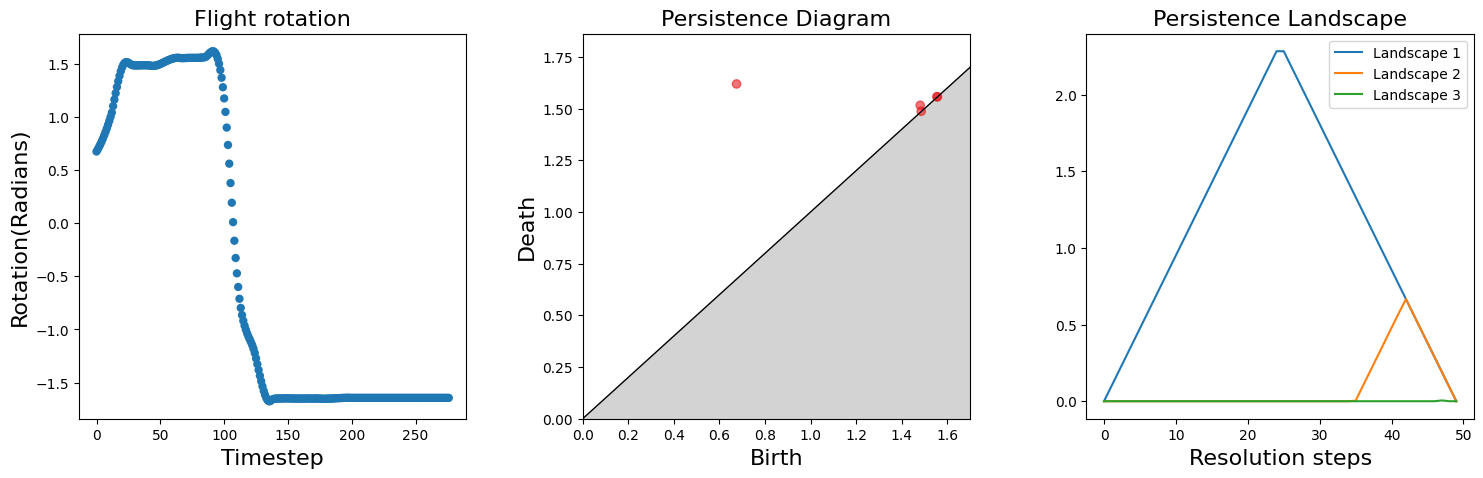

In [39]:
from gudhi.representations import Landscape

index = 200
dataset = 3

pers = pers_train[dataset]
pers.landscape_model = Landscape(num_landscapes=3, resolution=50, keep_endpoints=True)
pers.compute_landscapes()
fig = pers.plot_diagram(index, add_landscape=True)
#fig.savefig("H_example.svg", format="svg", dpi=1000)
pers.landscape_model = Landscape(num_landscapes=3, resolution=15, keep_endpoints=False)
pers.compute_landscapes()
None

In [40]:
def select_model(X, Y, seed, jobs=6):
    models = Models(seed).classifiers if classification else Models(seed).regressors
    kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
    
    trained_models = []
    scores = []

    for i in models.keys():
        model = GridSearchCV(
            models[i][0], 
            models[i][1],
            scoring="balanced_accuracy" if classification else "neg_root_mean_squared_error",
            cv=kfold,
            n_jobs=jobs
        )
        model.fit(X, Y)

        trained_models.append(model.best_estimator_)
        scores.append(model.best_score_)
    
    return trained_models, scores

In [41]:
def prepare_feature_combination(data_dict, feature_names):
    train_features = []
    test_features = []

    for feat_name in feature_names:
        train_feat, test_feat = data_dict[feat_name]
        if statistics:
            train_features.append(train_feat.stats if hasattr(train_feat, 'stats') else train_feat)
            test_features.append(test_feat.stats if hasattr(test_feat, 'stats') else test_feat)
        else:
            train_features.append(train_feat.landscapes if hasattr(train_feat, 'landscapes') else train_feat)
            test_features.append(test_feat.landscapes if hasattr(test_feat, 'landscapes') else test_feat)

    if len(feature_names) != 1:
        X_train = np.concatenate(train_features, axis=1)
        X_test = np.concatenate(test_features, axis=1)
    else:
        X_train = train_features[0]
        X_test = test_features[0]

    return X_train, X_test

In [42]:
feature_sets = ["B", "LL", "A", "S", "H"]
all_combinations = []

for r in range(1, len(feature_sets)+1):
    combinations_of_size_r = list(combinations(feature_sets, r))
    all_combinations.extend(combinations_of_size_r)

In [43]:
seed = 42

best_models = dict()
model_scores = dict()
pred_dict = dict()

for features in all_combinations:
    features_name = "+".join(features)

    X_train, X_test = prepare_feature_combination(data, features)
    y_train, y_test = prepare_feature_combination(data, ["y"])

    mask = np.logical_and(~np.any(np.isnan(X_train), axis=1), ~np.isnan(y_train))
    X_train = X_train[mask]
    y_train = y_train[mask]

    mask = np.logical_and(~np.any(np.isnan(X_test), axis=1), ~np.isnan(y_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    normalizer = preprocessing.StandardScaler()
    X_train = normalizer.fit_transform(X_train)
    X_test = normalizer.transform(X_test)

    models, scores = select_model(X_train, y_train, seed=seed, jobs=12)
    model_scores[features_name] = (models, scores)
    best_model = models[np.argmax(scores)]

    test_pred = best_model.predict(X_test)

    pred_dict[features_name] = (test_pred, y_test)

    if classification:
        final_score = balanced_accuracy_score(y_test, test_pred)
    else:
        final_score = root_mean_squared_error(y_test, test_pred)

    best_model_name = str(best_model).split("(")[0]
    best_models[features_name] = (best_model, best_model_name, final_score)
    print(f"{features_name} & {best_model_name} & {final_score:.3f}")

B & RandomForestRegressor & 0.245
LL & RandomForestRegressor & 0.378
A & MLPRegressor & 0.321
S & RandomForestRegressor & 0.310
H & RandomForestRegressor & 0.314
B+LL & RandomForestRegressor & 0.260
B+A & RandomForestRegressor & 0.250
B+S & RandomForestRegressor & 0.246
B+H & RandomForestRegressor & 0.229
LL+A & RandomForestRegressor & 0.294
LL+S & RandomForestRegressor & 0.298
LL+H & RandomForestRegressor & 0.322
A+S & RandomForestRegressor & 0.290
A+H & RandomForestRegressor & 0.263
S+H & RandomForestRegressor & 0.289
B+LL+A & RandomForestRegressor & 0.247
B+LL+S & RandomForestRegressor & 0.254
B+LL+H & RandomForestRegressor & 0.242
B+A+S & RandomForestRegressor & 0.244
B+A+H & RandomForestRegressor & 0.230
B+S+H & RandomForestRegressor & 0.234
LL+A+S & RandomForestRegressor & 0.269
LL+A+H & RandomForestRegressor & 0.267
LL+S+H & RandomForestRegressor & 0.295
A+S+H & RandomForestRegressor & 0.254
B+LL+A+S & RandomForestRegressor & 0.245
B+LL+A+H & RandomForestRegressor & 0.232
B+LL+S

In [44]:
print("[")
for feature_set, (_,_, final_score) in best_models.items():
    print(f"(\"{feature_set}\", {final_score:.3f}),")
print("]")

[
("B", 0.245),
("LL", 0.378),
("A", 0.321),
("S", 0.310),
("H", 0.314),
("B+LL", 0.260),
("B+A", 0.250),
("B+S", 0.246),
("B+H", 0.229),
("LL+A", 0.294),
("LL+S", 0.298),
("LL+H", 0.322),
("A+S", 0.290),
("A+H", 0.263),
("S+H", 0.289),
("B+LL+A", 0.247),
("B+LL+S", 0.254),
("B+LL+H", 0.242),
("B+A+S", 0.244),
("B+A+H", 0.230),
("B+S+H", 0.234),
("LL+A+S", 0.269),
("LL+A+H", 0.267),
("LL+S+H", 0.295),
("A+S+H", 0.254),
("B+LL+A+S", 0.245),
("B+LL+A+H", 0.232),
("B+LL+S+H", 0.241),
("B+A+S+H", 0.230),
("LL+A+S+H", 0.256),
("B+LL+A+S+H", 0.231),
]


In [45]:
for i, name in enumerate(model_scores["B"][0]):
    name = str(name).split("(")[0]
    mean = sum([score[1][i] for score in model_scores.values()])/len(model_scores)
    minimum = max([score[1][i] for score in model_scores.values()])
    maximum = min([score[1][i] for score in model_scores.values()])
    std = np.std([score[1][i] for score in model_scores.values()])
    print(f"{name} & {-mean:.3f} & {-minimum:.3f} & {-maximum:.3f} & {std:.4f} \\\\")

DummyRegressor & 0.800 & 0.800 & 0.801 & 0.0009 \\
SVR & 0.404 & 0.378 & 0.495 & 0.0218 \\
MLPRegressor & 0.514 & 0.420 & 0.623 & 0.0610 \\
KNeighborsRegressor & 0.413 & 0.385 & 0.471 & 0.0210 \\
RandomForestRegressor & 0.380 & 0.362 & 0.454 & 0.0198 \\
DecisionTreeRegressor & 0.429 & 0.403 & 0.501 & 0.0188 \\


In [46]:
best_B_models = sorted(
    (i for i, (_, _, score) in best_models.items() if "B" in i),
    key=lambda i: best_models[i][2],
    reverse=classification
)

# Filter and sort models not containing "B"
best_non_B_models = sorted(
    (i for i, (_, _, score) in best_models.items() if "B" not in i),
    key=lambda i: best_models[i][2],
    reverse=classification
)

best_B_model = best_B_models[0]
best_non_B_model = best_non_B_models[0]

In [47]:
best_non_B_model

'A+S+H'

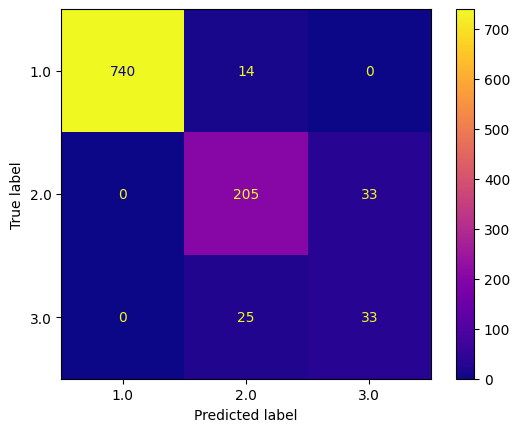

In [48]:
from sklearn.metrics import ConfusionMatrixDisplay

test_pred = pred_dict[best_B_model][0]
y_test = pred_dict[best_B_model][1]

display = ConfusionMatrixDisplay.from_predictions(y_test, np.round(test_pred), cmap="plasma")

if run_type == 0:
    display.figure_.savefig("./Thesis Plots/Experiment2/binary_confusion_matrix_statistics.svg", format="svg", bbox_inches="tight")
elif run_type == 1:
    display.figure_.savefig("./Thesis Plots/Experiment2/binary_confusion_matrix_landscapes.svg", format="svg", bbox_inches="tight")
elif run_type == 2:
    display.figure_.savefig("./Thesis Plots/Experiment3/unbalanced_confusion_matrix.svg", format="svg", bbox_inches="tight")
elif run_type == 3:
    display.figure_.savefig("./Thesis Plots/Experiment3/balanced_confusion_matrix.svg", format="svg", bbox_inches="tight")

2.3746272850931054 3.0


C:\Users\tobso\Desktop\programering\masters-thesis\functions\objects.py:86: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(path[:, 0], path[:, 1], cmap="plasma", edgecolors="none")


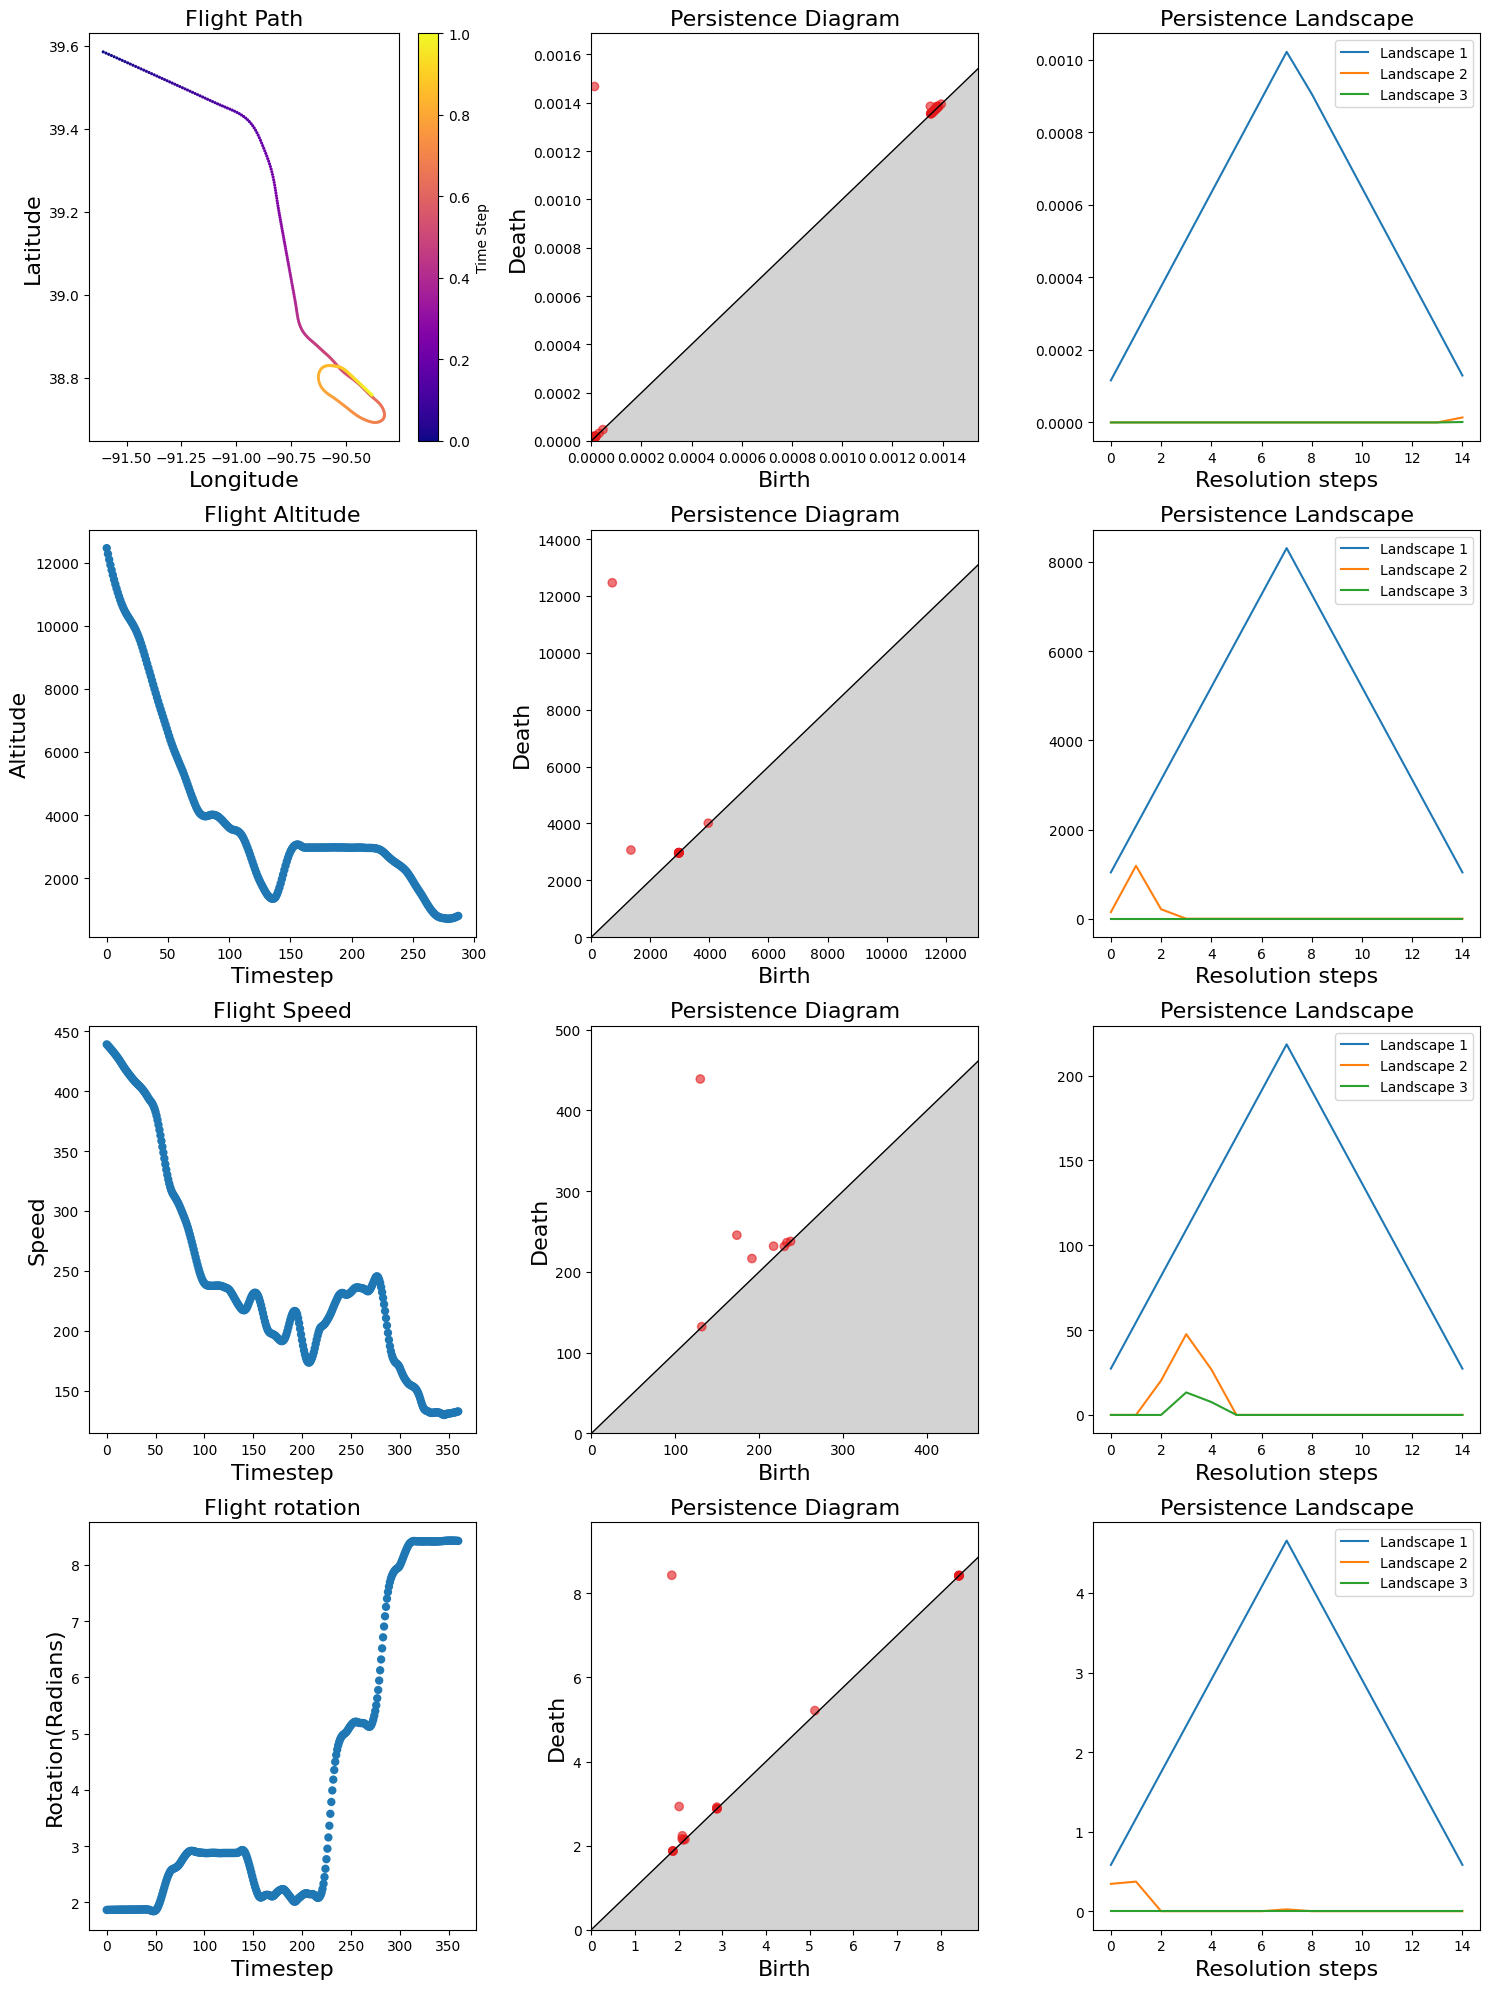

2.460545137681537 3.0


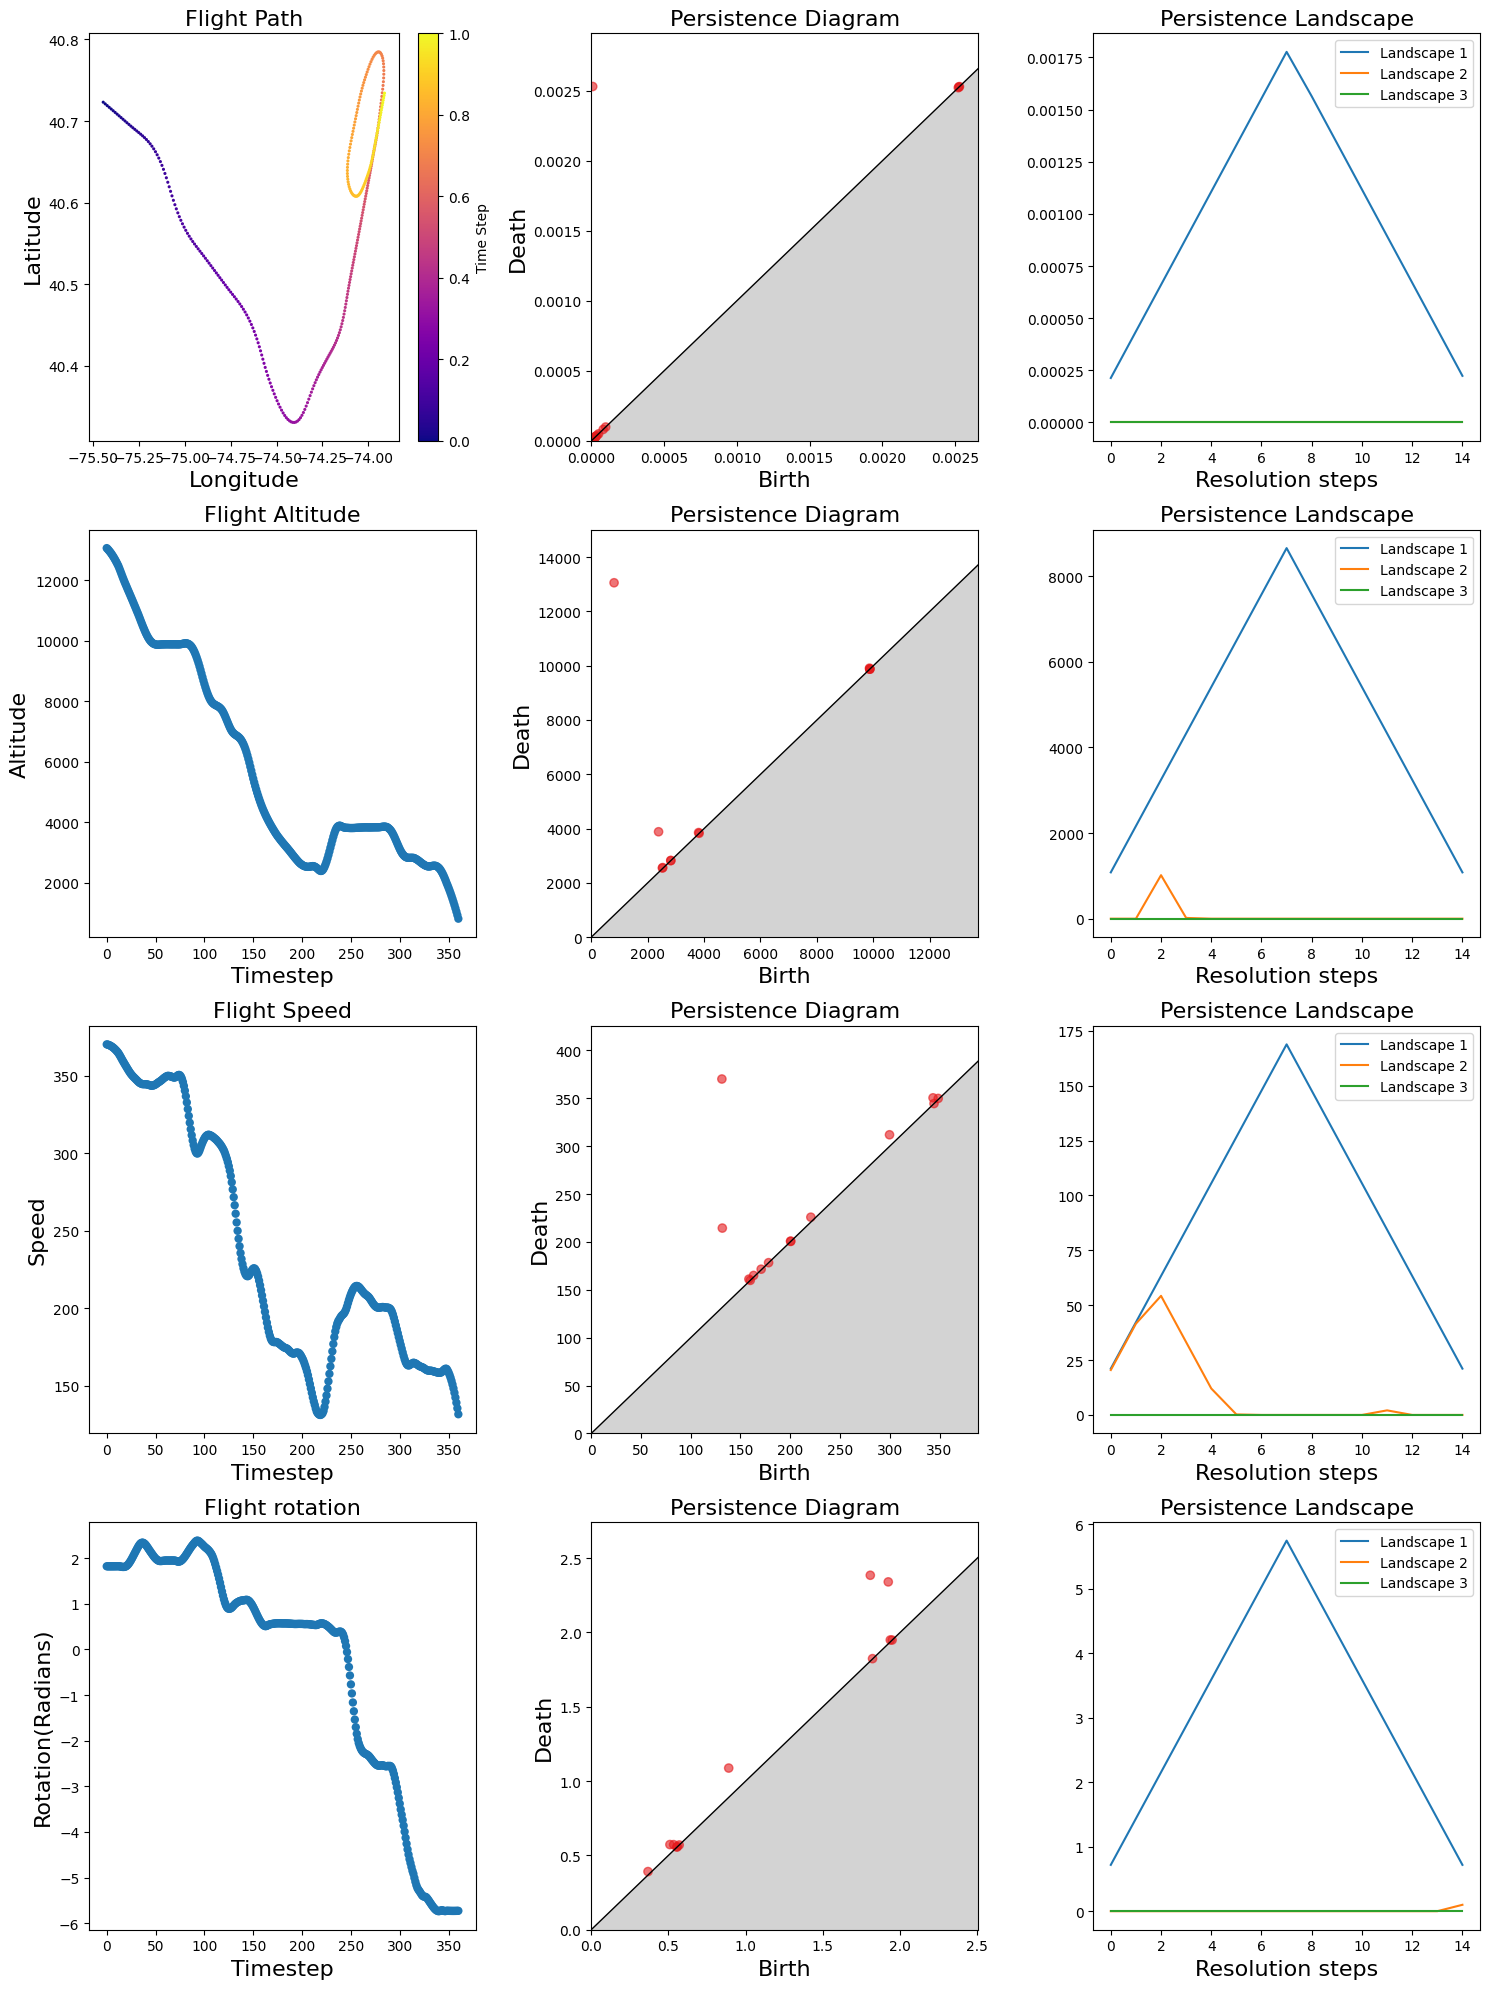

2.4977601532477745 3.0


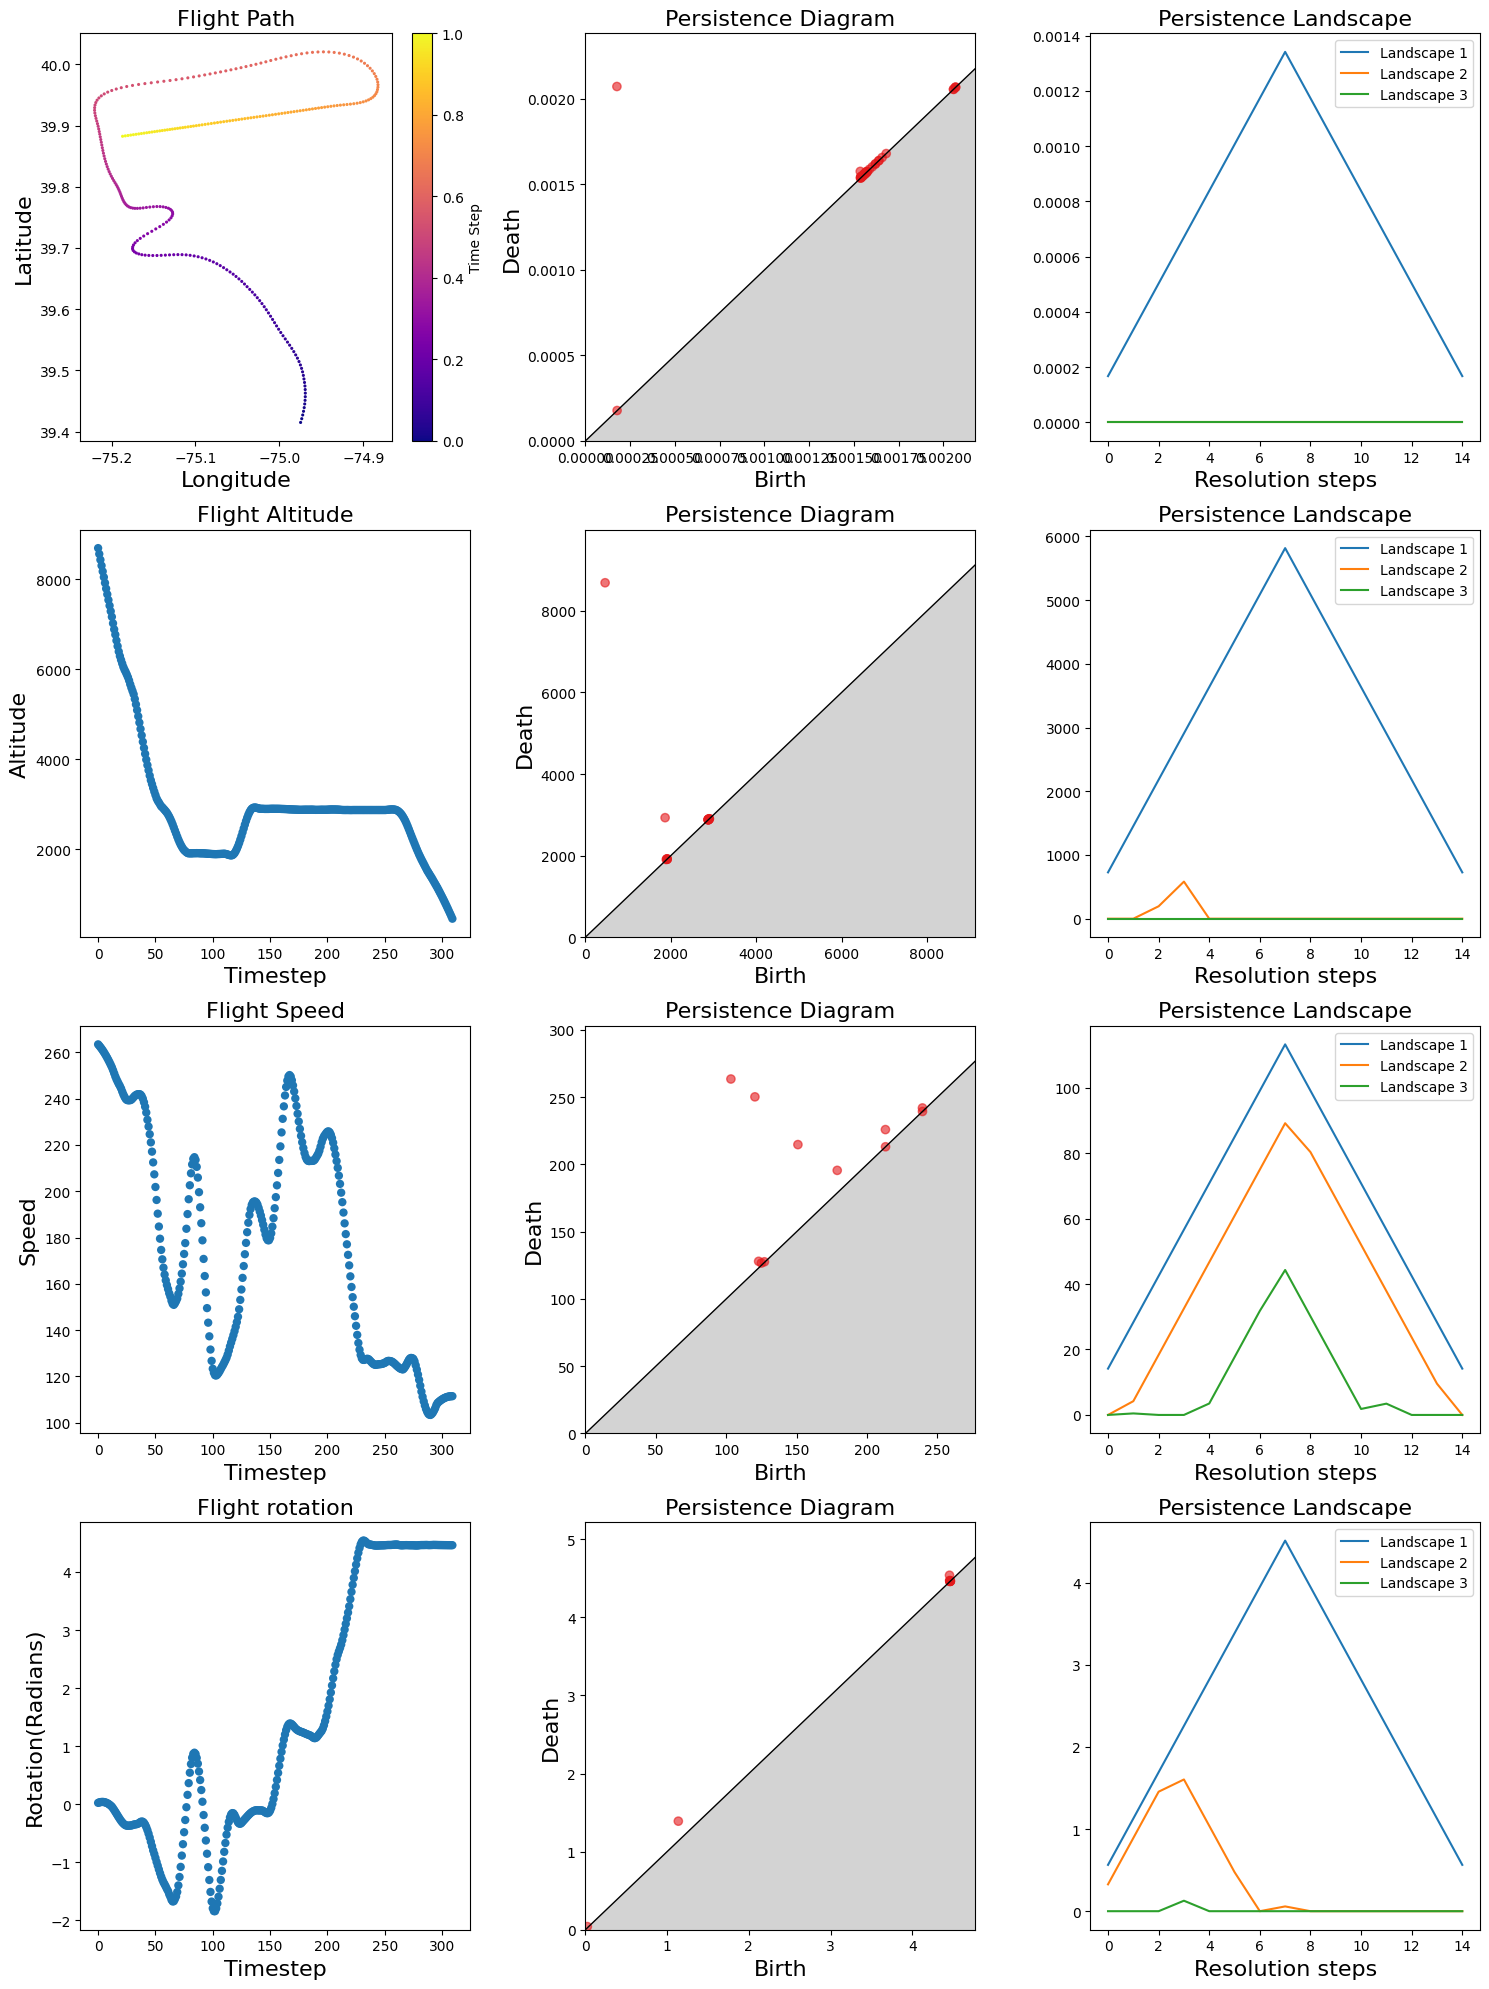

''

In [56]:
errors = np.where(np.round(test_pred) != y_test)

np.random.seed(43)
samples = np.random.choice(errors[0], 3,)

for i in samples:
    print(test_pred[i], y_test[i])

    LL_data: PersistenceData = data["LL"][1]
    A_data: PersistenceData = data["A"][1]
    S_data: PersistenceData = data["S"][1]
    H_data: PersistenceData = data["H"][1]

    fig = PersistenceData.plot_multiple_diagrams([LL_data, A_data,S_data, H_data], i, add_landscape=True)
    fig.savefig(f"./Thesis plots/experiment3/balanced_error_{i}.svg", format="svg", bbox_inches="tight")
;

In [50]:
analysis_results = {}

for target_feature in feature_sets:
    with_scores = {}
    without_scores = {}

    for features_name, (_, _, score) in best_models.items():
        features = features_name.split("+")
        features_set = set(features)

        if target_feature in features_set:
            base_key = tuple(sorted(features_set - {target_feature}))
            with_scores[base_key] = score
        else:
            base_key = tuple(sorted(features_set))
            without_scores[base_key] = score

    diffs = []

    # Compare only if both versions exist
    for base_key in without_scores:
        if base_key in with_scores:
            diff = with_scores[base_key] - without_scores[base_key]
            diffs.append(diff)

    avg_without = sum(without_scores.values()) / len(without_scores) if without_scores else None
    avg_with = sum(with_scores.values()) / len(with_scores) if with_scores else None
    avg_diff = sum(diffs) / len(diffs) if diffs else None
    best_improvement = max(diffs) if diffs else None
    smallest_improvement = min(diffs) if diffs else None

    analysis_results[target_feature] = {
        "avg_without": avg_without,
        "avg_with": avg_with,
        "avg_diff": avg_diff,
        "max_change": best_improvement,
        "min_change": smallest_improvement,
    }
for features_name, info_dict in analysis_results.items():
    print(f"{features_name} & {' & '.join([f'{j:.4f}' for i, j in info_dict.items()])}")

B & 0.2945 & 0.2412 & -0.0536 & -0.0237 & -0.1177
LL & 0.2632 & 0.2706 & 0.0002 & 0.0153 & -0.0269
A & 0.2771 & 0.2575 & -0.0238 & 0.0054 & -0.0832
S & 0.2728 & 0.2615 & -0.0145 & 0.0059 & -0.0797
H & 0.2766 & 0.2580 & -0.0224 & -0.0033 & -0.0583


In [51]:
import pandas as pd

# Persistence landscapes data
landscapes_results = [
("B", 0.994), ("LL", 0.948), ("A", 0.954), ("S", 0.966), ("H", 0.965), ("B+LL", 0.995), ("B+A", 0.995), ("B+S", 0.997), ("B+H", 0.994), ("LL+A", 0.968), ("LL+S", 0.982), ("LL+H", 0.964), ("A+S", 0.980), ("A+H", 0.977), ("S+H", 0.984), ("B+LL+A", 0.993), ("B+LL+S", 0.998), ("B+LL+H", 0.995), ("B+A+S", 0.995), ("B+A+H", 0.988), ("B+S+H", 0.993), ("LL+A+S", 0.980), ("LL+A+H", 0.981), ("LL+S+H", 0.980), ("A+S+H", 0.982), ("B+LL+A+S", 0.996), ("B+LL+A+H", 0.993), ("B+LL+S+H", 0.995), ("B+A+S+H", 0.995), ("LL+A+S+H", 0.986), ("B+LL+A+S+H", 0.992),
]

# Persistence statistics data
statistics_results = [
("B", 0.994), ("LL", 0.961), ("A", 0.983), ("S", 0.985), ("H", 0.978), ("B+LL", 0.994), ("B+A", 0.994), ("B+S", 0.993), ("B+H", 0.997), ("LL+A", 0.987), ("LL+S", 0.988), ("LL+H", 0.976), ("A+S", 0.992), ("A+H", 0.995), ("S+H", 0.991), ("B+LL+A", 0.993), ("B+LL+S", 0.993), ("B+LL+H", 0.994), ("B+A+S", 0.999), ("B+A+H", 0.995), ("B+S+H", 0.998), ("LL+A+S", 0.991), ("LL+A+H", 0.983), ("LL+S+H", 0.990), ("A+S+H", 0.996), ("B+LL+A+S", 0.991), ("B+LL+A+H", 0.993), ("B+LL+S+H", 0.997), ("B+A+S+H", 0.997), ("LL+A+S+H", 0.993), ("B+LL+A+S+H", 0.996),
]

# Create DataFrames
df_landscapes = pd.DataFrame(landscapes_results, columns=["Feature-set combination", "Landscapes"])
df_statistics = pd.DataFrame(statistics_results, columns=["Feature-set combination", "Statistics"])

# Merge datasets on the feature-set combination
df = pd.merge(df_landscapes, df_statistics, on="Feature-set combination", how="inner")

# Calculate the difference
df["Difference"] =  df["Statistics"] - df["Landscapes"]

# Compute summary statistics
avg_landscapes = df["Landscapes"].mean()
avg_statistics = df["Statistics"].mean()
avg_difference = df["Difference"].mean()
max_change = df["Difference"].max()
min_change = df["Difference"].min()

# Print results
print(f"Average Landscapes: {avg_landscapes:.4f}")
print(f"Average Statistics: {avg_statistics:.4f}")
print(f"Average Difference (Landscapes - Statistics): {avg_difference:.4f}")
print(f"Max Change: {max_change:.4f}")
print(f"Min Change: {min_change:.4f}")

Average Landscapes: 0.9840
Average Statistics: 0.9905
Average Difference (Landscapes - Statistics): 0.0065
Max Change: 0.0290
Min Change: -0.0050


In [52]:
import pandas as pd
import statsmodels.api as sm

df = pd.DataFrame(statistics_results, columns=["features", "score"])

# One-hot encode feature presence
for feat in ["B", "LL", "A", "S", "H"]:
    df[feat] = df["features"].apply(lambda x: int(feat in x.split("+")))

# Define X and y
X = df[["B", "LL", "A", "S", "H"]]
y = df["score"]

# Add constant (intercept)
X = sm.add_constant(X)

# Fit linear regression
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     8.470
Date:                Sun, 07 Sep 2025   Prob (F-statistic):           8.50e-05
Time:                        15:04:05   Log-Likelihood:                 122.24
No. Observations:                  31   AIC:                            -232.5
Df Residuals:                      25   BIC:                            -223.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9805      0.003    390.728      0.0

In [1]:
unbalanced_regression_results = [
("B", 0.244), ("LL", 0.324), ("A", 0.287), ("S", 0.271), ("H", 0.272), ("B+LL", 0.243), ("B+A", 0.239), ("B+S", 0.243), ("B+H", 0.227), ("LL+A", 0.266), ("LL+S", 0.273), ("LL+H", 0.260), ("A+S", 0.250), ("A+H", 0.247), ("S+H", 0.248), ("B+LL+A", 0.240), ("B+LL+S", 0.242), ("B+LL+H", 0.223), ("B+A+S", 0.240), ("B+A+H", 0.225), ("B+S+H", 0.229), ("LL+A+S", 0.247), ("LL+A+H", 0.245), ("LL+S+H", 0.250), ("A+S+H", 0.243), ("B+LL+A+S", 0.237), ("B+LL+A+H", 0.224), ("B+LL+S+H", 0.226), ("B+A+S+H", 0.230), ("LL+A+S+H", 0.244), ("B+LL+A+S+H", 0.227), ]

balanced_regression_results = [
("B", 0.245), ("LL", 0.378), ("A", 0.321), ("S", 0.310), ("H", 0.314), ("B+LL", 0.260), ("B+A", 0.250), ("B+S", 0.246), ("B+H", 0.229), ("LL+A", 0.294), ("LL+S", 0.298), ("LL+H", 0.322), ("A+S", 0.290), ("A+H", 0.263), ("S+H", 0.289), ("B+LL+A", 0.247), ("B+LL+S", 0.254), ("B+LL+H", 0.242), ("B+A+S", 0.244), ("B+A+H", 0.230), ("B+S+H", 0.234), ("LL+A+S", 0.269), ("LL+A+H", 0.267), ("LL+S+H", 0.295), ("A+S+H", 0.254), ("B+LL+A+S", 0.245), ("B+LL+A+H", 0.232), ("B+LL+S+H", 0.241), ("B+A+S+H", 0.230), ("LL+A+S+H", 0.256), ("B+LL+A+S+H", 0.231), ]

In [54]:
# Create DataFrames
df_unbalanced = pd.DataFrame(unbalanced_regression_results, columns=["Feature-set combination", "unbalanced"])
df_balanced = pd.DataFrame(balanced_regression_results, columns=["Feature-set combination", "balanced"])

# Merge datasets on the feature-set combination
df = pd.merge(df_unbalanced, df_balanced, on="Feature-set combination", how="inner")

# Calculate the difference
df["Difference"] =  df["unbalanced"] - df["balanced"]

# Compute summary statistics
avg_unbalanced = df["unbalanced"].mean()
avg_balanced = df["balanced"].mean()
avg_difference = df["Difference"].mean()
max_change = df["Difference"].max()
min_change = df["Difference"].min()

# Print results
print(f"Average unbalanced: {avg_unbalanced:.4f}")
print(f"Average balanced: {avg_balanced:.4f}")
print(f"Average Difference (unbalanced - balanced): {avg_difference:.4f}")
print(f"Max Change: {max_change:.4f}")
print(f"Min Change: {min_change:.4f}")

Average unbalanced: 0.2473
Average balanced: 0.2671
Average Difference (unbalanced - balanced): -0.0198
Max Change: 0.0000
Min Change: -0.0620


In [3]:
import pandas as pd
import statsmodels.api as sm
import pandas as pd

df = pd.DataFrame(balanced_regression_results, columns=["features", "score"])

# One-hot encode feature presence
for feat in ["B", "LL", "A", "S", "H"]:
    df[feat] = df["features"].apply(lambda x: int(feat in x.split("+")))

# Define X and y
X = df[["B", "LL", "A", "S", "H"]]
y = df["score"]

# Add constant (intercept)
X = sm.add_constant(X)

# Fit linear regression
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     21.29
Date:                Mon, 08 Sep 2025   Prob (F-statistic):           2.80e-08
Time:                        19:08:13   Log-Likelihood:                 85.631
No. Observations:                  31   AIC:                            -159.3
Df Residuals:                      25   BIC:                            -150.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3239      0.008     39.630      0.0